In [2]:
import sys
sys.path.append("..")

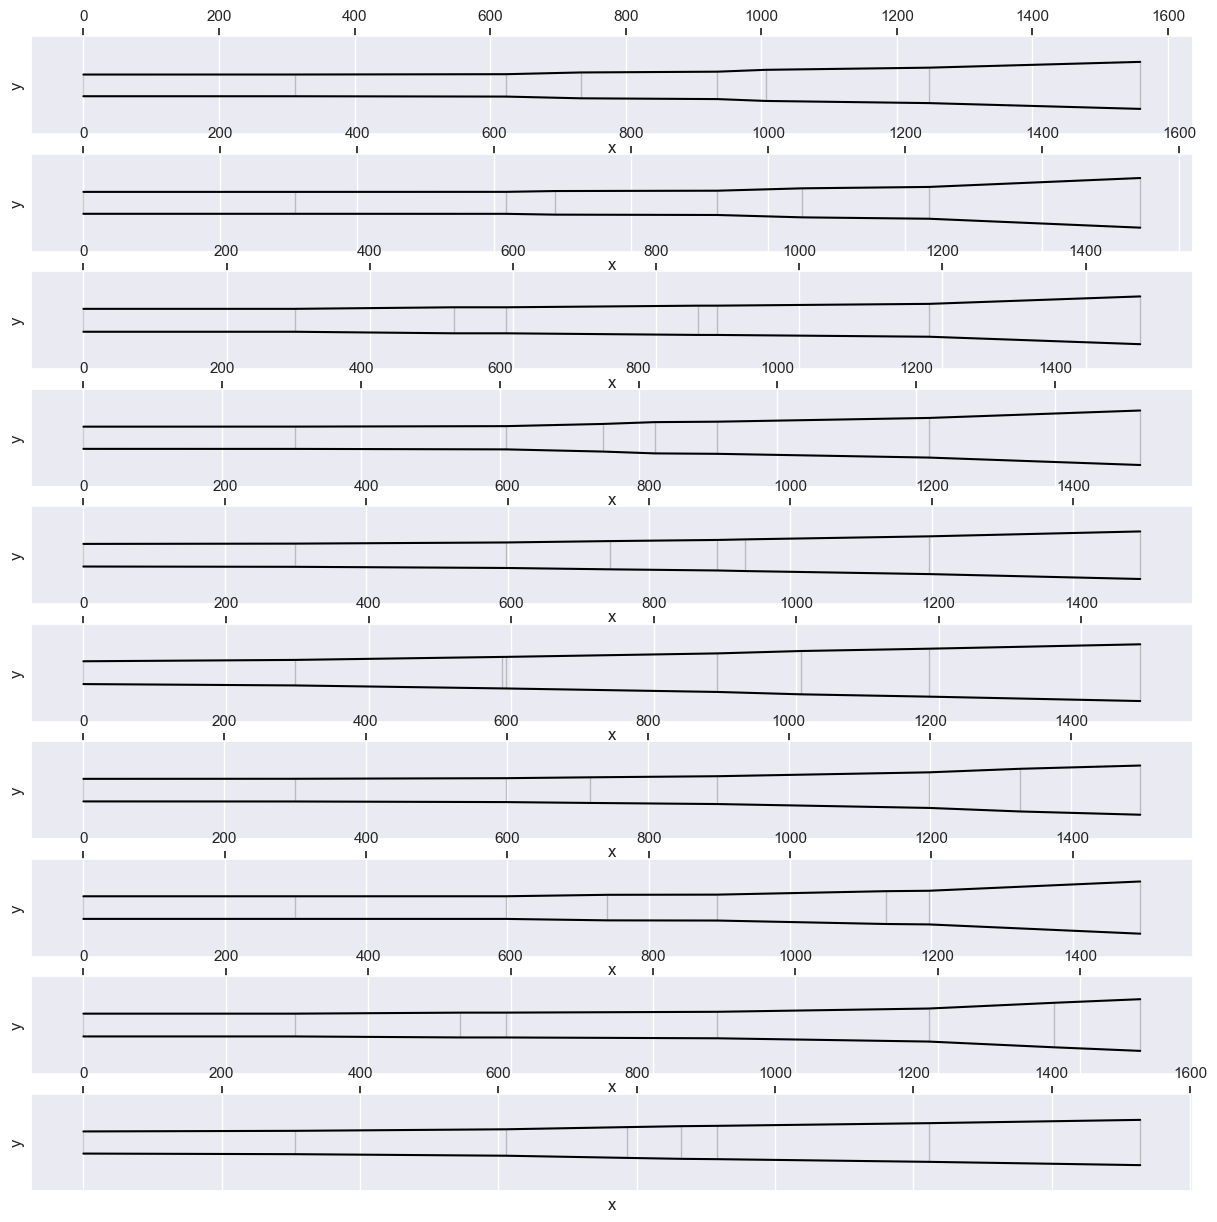

In [76]:
from didgelab.evo.shapes import Shape
from didgelab.calc.geo import Geo, geotools
from didgelab.calc.conv import note_to_freq
from didgelab.util.didge_visualizer import vis_didge
from didgelab.evo.mutator import MutationRateMutator
import numpy as np

import matplotlib.pyplot as plt
import json
class BasicShape(Shape):
    
    def __init__(
            self,
            n_bubbles=1,
            n_bubble_segments=10,
            n_segments = 10
        ):
        
        Shape.__init__(self)

        self.d1=32
        self.n_segments = n_segments
        
        self.add_param("length", 1450, 1600)
        self.add_param("bellsize", 65, 80)
        self.add_param("power", 1,2)
        
        self.add_param("widening_1_x", 500, 800)
        self.add_param("widening_1_y", 1.0, 1.3)
        self.add_param("widening_2_x", 800, 1400)
        self.add_param("widening_2_y", 1.0, 1.3)
        
        self.n_bubbles=n_bubbles
        self.n_bubble_segments=10
        for i in range(self.n_bubbles):
            self.add_param(f"bubble{i}_width", 100, 200)
            self.add_param(f"bubble{i}_height", 0, 15)
            self.add_param(f"bubble{i}_pos", -0.3, 0.3)
        
    def make_geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")

        x = length*np.arange(self.n_segments+1)/self.n_segments
        y= np.arange(self.n_segments+1)/self.n_segments
        
        
        p = self.get_value("power")
        y = np.power(y, p)
        y = np.power(y, p)
        y = np.power(y, p)
        y = self.d1 + y*(bellsize - self.d1)
        
        widenings = [[self.get_value(f"widening_{i}_x"), self.get_value(f"widening_{i}_y")] for i in range(1,3)]
        for w in widenings:
            geo = list(zip(x,y))
            d=geotools.diameter_at_x(Geo(geo), w[0])
            
            add_d = w[1]*d - d
            for i in range(len(geo)):
                if geo[i][0] >= w[0]:
                    break
            
            x = np.concatenate((x[0:i], [w[0]], x[i:]))
            y_right = np.concatenate(([d], y[i:])) + add_d
            y = np.concatenate((y[0:i], y_right))
        
            y[i:] /= y[-1]/bellsize
            
        shape = list(zip(x,y))
        
        bubble_length = length-100

        for i in range(self.n_bubbles):
            
            width = self.get_value(f"bubble{i}_width")
            height = self.get_value(f"bubble{i}_height")
            pos = self.get_value(f"bubble{i}_pos")
                
            x = width * np.arange(self.n_bubble_segments)/self.n_bubble_segments
            y = height * np.sin(np.arange(self.n_bubble_segments)*np.pi/self.n_bubble_segments)
            
            x += bubble_length * i/self.n_bubbles
            x += (0.5+pos)*bubble_length/self.n_bubbles
                        
            if x[0] < 0:
                x += -1*x[0]
                x += 1
            if x[-1] > bubble_length:
                x -= x[-1] - (bubble_length)
            
            geo = Geo(shape)
            y += np.array([geotools.diameter_at_x(geo, _x) for _x in x])
            
            shape = list(filter(lambda a : a[0]<x[0] or a[0]>x[-1], shape))
            shape.extend(zip(x,y))
            shape = sorted(shape, key=lambda x : x[0])
        
        return Geo(shape)
    
class DetailShape(Shape):
    
    def __init__(self, father_shape : Shape):
        Shape.__init__(self)
        
        geo = father_shape.make_geo().geo
        self.d1 = geo[0][1]
        self.update_parameters(geo)
            
    def update_parameters(self, geo):
        self.parameters = []
        self.num_segments = len(geo)
        for i in range(1, len(geo)):
            x=geo[i][0]
            minx = np.max((0.8*x, geo[i-1][0]*1.1))
            maxx = 1.2*x
            if i<len(geo)-1:
                maxx = np.min((maxx, geo[i+1][0]*0.9))
            self.add_param(f"x{i}", minx, maxx, value=x)
            
            y=geo[i][1]
            miny = 0.8*y
            maxy = 1.2*y
            self.add_param(f"y{i}", miny, maxy, value=y)
        
            
    def make_geo(self):
        x = [0]
        y = [self.d1]
        for i in range(1, self.num_segments):
            x.append(self.get_value(f"x{i}"))
            y.append(self.get_value(f"y{i}"))
        geo = list(zip(x,y))
        geo = sorted(geo, key=lambda x : x[0])
        self.update_parameters(geo)
        return Geo(geo)
            
    
father = BasicShape(n_bubbles=0, n_segments=5)
#detail = DetailShape(father)
mutator = MutationRateMutator()

n_mutants=10
mutants = [mutator.mutate(father) for i in range(n_mutants)]

plt.figure(figsize=(15,15))
for i in range(len(mutants)):
    plt.subplot(len(mutants), 1, i+1)
    vis_didge(mutants[i].make_geo())


In [283]:
class MutationRateMutator:

    def __init__(self):
        pass

    def mutate(self, father, mutation_rate=1.0, mutation_probability = 1.0):
        mutant = father.copy()

        maxima = np.array([x.maximum for x in mutant.parameters])
        minima = np.array([x.minimum for x in mutant.parameters])
        values = np.array([x.value for x in mutant.parameters])

        diff = mutation_rate * ((np.random.random(len(values))  * (maxima-minima) ) + minima - values)
        print(diff[0])
        mutations = np.array([0.0])
        i=0
        while mutations.sum() == 0.0 and i<10:
            mutations = np.random.choice((1,0), size=len(diff), p=(mutation_probability, 1-mutation_probability))
            i+=1

        diff = diff*mutations

        new_values = values + diff

        # make shure the values are within minima and maxima range
        new_values_before = new_values.copy()
        indizes = new_values<minima
        new_values[indizes] = minima[indizes]
        indizes = new_values>maxima
        new_values[indizes] = maxima[indizes]

        for i in range(len(new_values)):
            mutant.parameters[i].value = new_values[i]

        mutant.loss = -1

        return mutant
    
mutator = MutationRateMutator()

n_mutants=10
mutants = [mutator.mutate(father) for i in range(n_mutants)]

lengths = [m.get_value("length") for m in mutants]
lengths

42.06264697975098
40.514288599618794
-32.44848984239775
65.92269758266002
-66.17763069594912
-67.48115651174794
-62.887582630448605
-7.063133875678204
16.772829233621906
0.5862343947110276


[1567.062646979751,
 1565.5142885996188,
 1492.5515101576023,
 1590.92269758266,
 1458.8223693040509,
 1457.518843488252,
 1462.1124173695514,
 1517.9368661243218,
 1541.772829233622,
 1525.586234394711]

In [9]:
from didgelab.evo.evolution import Evolution
from didgelab.initializer import init_jupyter

init_jupyter()
basic_shape = BasicShape(
    n_bubbles=0
)



2023-09-06 15:14:54,422 [INFO] {app.py:129} 
 _____  _     _              _           _     
|  __ \(_)   | |            | |         | |    
| |  | |_  __| | __ _  ___  | |     __ _| |__  
| |  | | |/ _` |/ _` |/ _ \ | |    / _` | '_ \ 
| |__| | | (_| | (_| |  __/ | |___| (_| | |_) |
|_____/|_|\__,_|\__, |\___| |______\__,_|_.__/ 
                 __/ |                         
                |___/                          
Starting /Users/jane03/miniconda3/envs/didge/lib/python3.10/site-packages/ipykernel_launcher.py -f /Users/jane03/Library/Jupyter/runtime/kernel-b9fc3717-21b5-4e58-b3e9-3990164e5f04.json
2023-09-06 15:14:54,422 [INFO] {app.py:129} 
 _____  _     _              _           _     
|  __ \(_)   | |            | |         | |    
| |  | |_  __| | __ _  ___  | |     __ _| |__  
| |  | | |/ _` |/ _` |/ _ \ | |    / _` | '_ \ 
| |__| | | (_| | (_| |  __/ | |___| (_| | |_) |
|_____/|_|\__,_|\__, |\___| |______\__,_|_.__/ 
                 __/ |                         
    

In [ ]:
from loss 

evo = Evolution(
    num_generations=100,
    generation_size=100,
    population_size=5
)


,freq,impedance,rel_imp,note-number,cent-diff,note-name
796,75.246745,2.989998e+07,1.000000,-31,-42.637059,D1
1531,175.893366,9.790558e+06,0.327444,-16,-12.637059,F2
1947,284.422265,4.309639e+06,0.144135,-8,-44.637059,C#3
2236,397.154699,3.485876e+06,0.116585,-2,-22.637059,G3
2448,507.368659,1.672984e+06,0.055953,2,-46.637059,B4
2622,620.329359,1.253444e+06,0.041921,6,5.362941,D#4
2760,727.543952,1.111176e+06,0.037163,9,29.362941,F#4
2893,848.374391,7.196243e+05,0.024068,11,-36.637059,G#4
2997,956.678652,6.380108e+05,0.021338,13,-44.637059,A#5


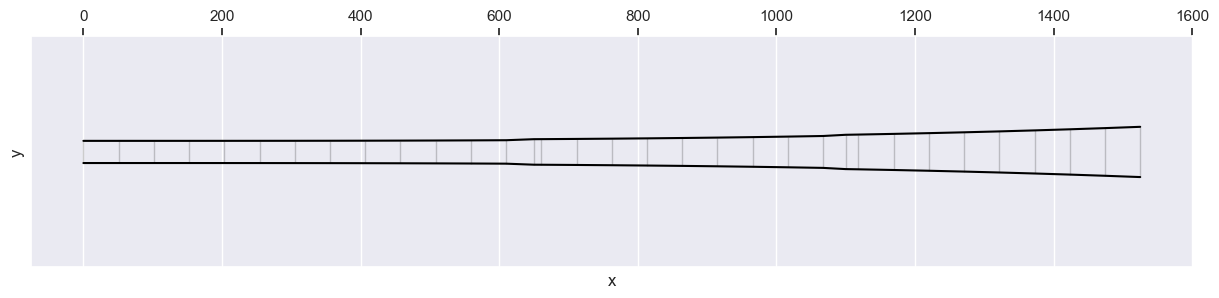

In [26]:
shape2 = BasicShape(n_bubbles=0, n_segments=30)
geo2 = shape2.make_geo()
vis_didge(geo2)
geo2.get_cadsd().get_notes()

,freq,impedance,rel_imp,note-number,cent-diff,note-name
793,74.986411,2.579968e+07,1.000000,-31,-36.637059,D1
1530,175.690284,6.232947e+06,0.241590,-16,-10.637059,F2
1931,279.213314,5.473507e+06,0.212154,-8,-12.637059,C#3
2216,388.083673,2.502280e+06,0.096989,-2,17.362941,G3
2445,505.613297,4.412596e+05,0.017103,2,-40.637059,B4
2610,611.789101,1.021711e+06,0.039602,6,29.362941,D#4
2738,709.286131,1.798493e+06,0.069710,8,-26.637059,F4
2930,885.423546,4.590832e+05,0.017794,12,-10.637059,A5


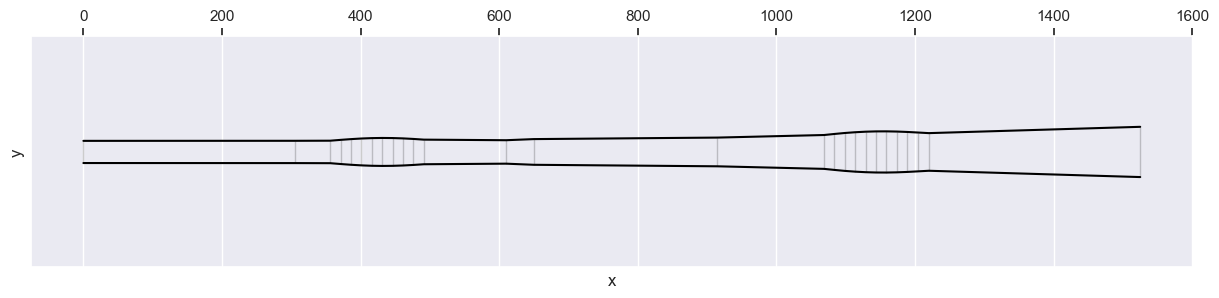

In [39]:
class DetailShape(Shape):
    
    def __init__(self, father_shape : Shape):
        Shape.__init__(self)
        
        geo = father_shape.make_geo().geo
        self.d1 = geo[0][1]
        self.num_segments = len(geo)
        for i in range(1, len(geo)):
            x=geo[i][0]
            minx = 0.8*x
            maxx = 1.2*x
            self.add_param(f"x{i}", minx, maxx, value=x)
            
            y=geo[i][1]
            miny = 0.8*y
            maxy = 1.2*y
            self.add_param(f"y{i}", miny, maxy, value=y)
            
            
    def make_geo(self):
        x = [0]
        y = [self.d1]
        for i in range(1, self.num_segments):
            x.append(self.get_value(f"x{i}"))
            y.append(self.get_value(f"y{i}"))
        geo = list(zip(x,y))
        return Geo(geo)
            
shape3 = DetailShape(shape1)
geo3 = shape3.make_geo()
vis_didge(geo3)
geo3.get_cadsd().get_notes()

../../evolutions/2023-09-06T16-21-54_test


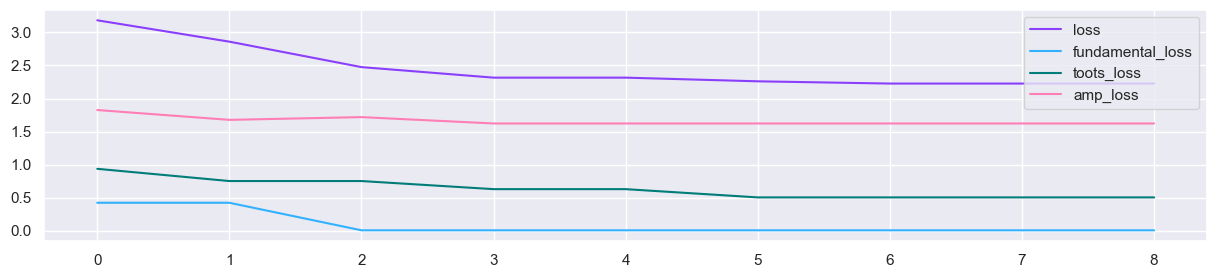

In [95]:
import pandas as pd
import os
evolutions_folder="../../evolutions/"
subfolders = sorted(os.listdir(evolutions_folder))
latestfolder = os.path.join(evolutions_folder, subfolders[-1])
print(latestfolder)
df = pd.read_csv(os.path.join(latestfolder, "losses.csv"))
steps = []
df = df.query("i_generation<i_generation.max()")
df

x = df.i_generation.unique()

columns=list(df.columns)
columns=columns[columns.index("loss"):]
colors = ['#8a3ffc', '#33b1ff', '#007d79', '#ff7eb6', '#fa4d56', '#fff1f1', '#6fdc8c', '#4589ff', '#d12771', '#d2a106', '#08bdba', '#bae6ff', '#ba4e00', '#d4bbff']
for i in range(len(columns)):
    c = columns[i]
    ymin=df.groupby("i_generation")[c].min()
    #ymax=df.groupby("i_generation")[c].max()
    #plt.fill_between(x, ymin, ymax, label=c, color=colors[i])
    plt.plot(x, ymin, label=c, color=colors[i])

plt.legend()
#for i_mutant in df.i_mutant.unique():
#    plt.plot(x,df.query("i_mutant==@i_mutant").loss)


['D1', 'F2', 'C3', 'F#3', 'B4', 'D4', 'F4', 'A5']
['D1', 'E2', 'C#3', 'F#3', 'B4', 'D4', 'F4', 'G#4', 'A5', 'B5']
['D1', 'F#2', 'C#3', 'G#3', 'D4', 'F#4', 'A#5']
['D1', 'E2', 'C#3', 'F#3', 'B4', 'D4', 'F4', 'A5']
['D1', 'E2', 'C#3', 'G3', 'B4', 'D#4', 'F4', 'A5']
['D1', 'E2', 'C#3', 'F#3', 'B4', 'D4', 'F4', 'A5']
['D1', 'F2', 'D3', 'G3', 'B4', 'D#4', 'F4', 'A5']
['D1', 'F2', 'C3', 'G3', 'A#4', 'D4', 'F4', 'B5']
['D1', 'F2', 'C#3', 'G3', 'C4', 'D#4', 'F#4', 'G#4', 'B5']
['D1', 'F2', 'C#3', 'G3', 'B4', 'D4', 'F4', 'A5', 'B5']


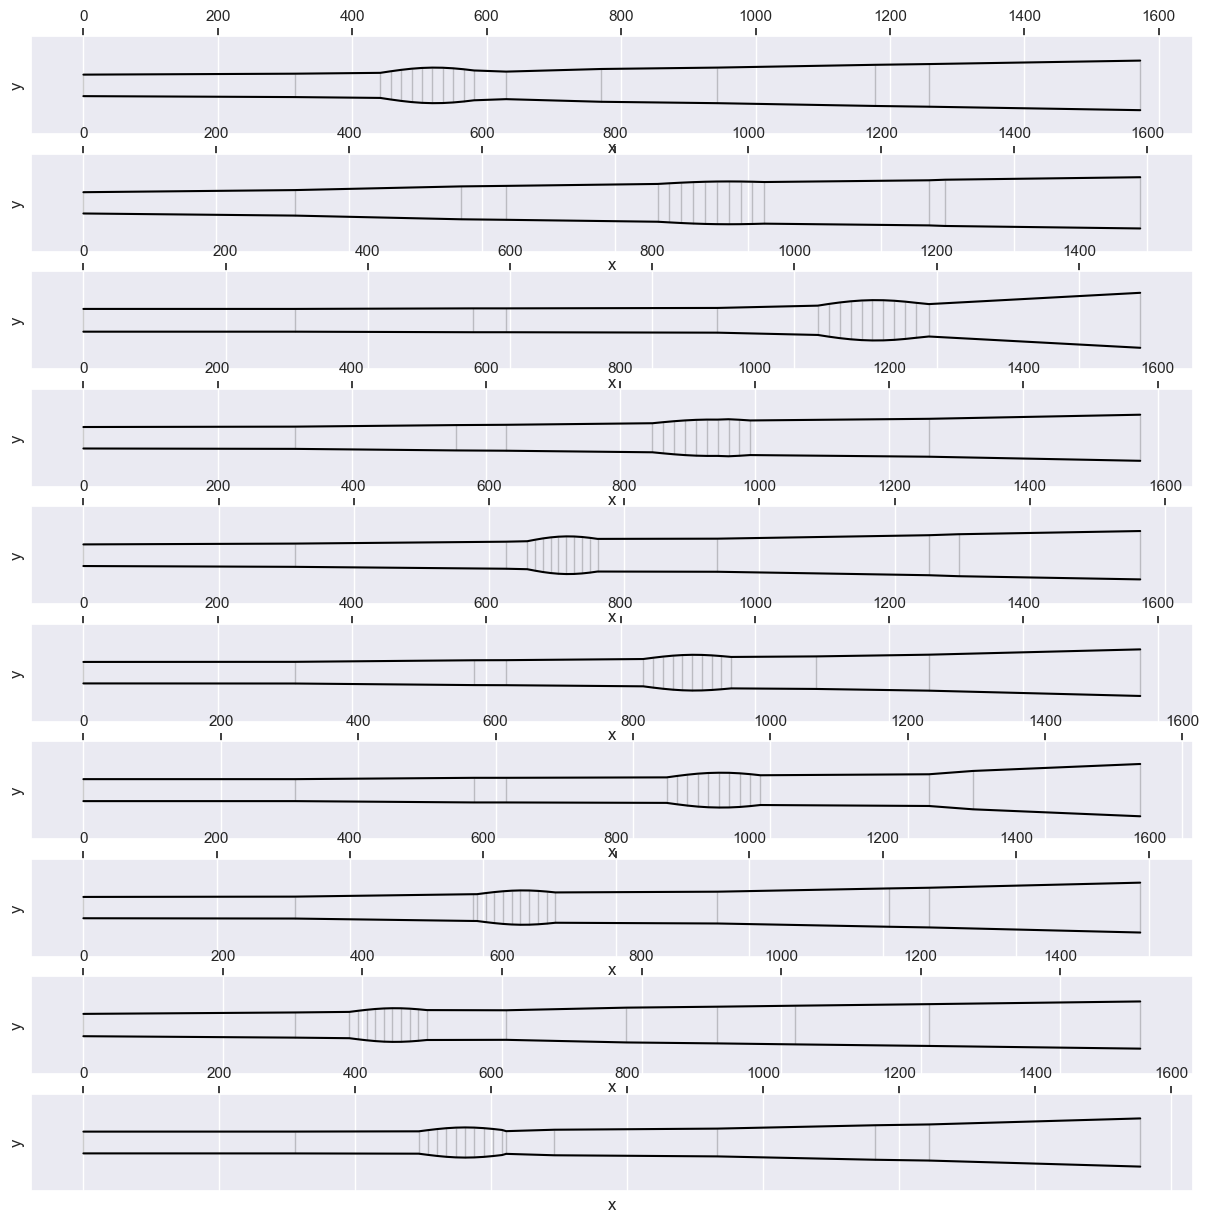

In [96]:
from didgelab.util.didge_visualizer import vis_didge

import json
f = os.path.join(latestfolder, "checkpoint_final", "geos.json")
geos = json.load(open(f, "r"))
geos = [Geo(geo) for geo in geos]
plt.figure(figsize=(15,15))
for i in range(len(geos)):
    plt.subplot(len(geos), 1, i+1)
    vis_didge(geos[i])

for geo in geos:
    print(list(geo.get_cadsd().get_notes()["note-name"]))

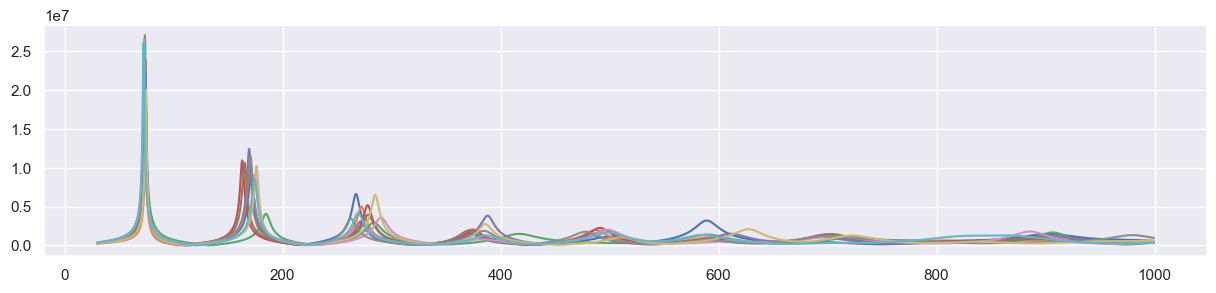

In [97]:
for geo in geos:
    c=geo.get_cadsd().get_impedance_spektrum()
    plt.plot(c.freq, c.impedance)

In [99]:
for geo in geos:
    c=geo.get_cadsd().get_ground_spektrum()
    print(c)
    plt.plot(c.freq, c.impedance)

KeyError: 31

In [82]:
import pickle
f = os.path.join(latestfolder, "checkpoint_final", "shapes.bin")
shapes = pickle.load(open(f, "rb"))
shapes[0]

           name    value      min      max
0        length  1566.75  1450.00  1600.00
1      bellsize    75.46    65.00    80.00
2         power     1.55     1.00     2.00
3  widening_1_x   560.96   500.00   800.00
4  widening_1_y     1.25     1.00     1.30
5  widening_2_x  1227.50   800.00  1400.00
6  widening_2_y     1.21     1.00     1.30

In [47]:
Geo(geos[0]).get_cadsd().get_notes().iloc[0]["freq"]

119.03350709156146

In [33]:
x=10
y=np.log2(x)
np.power(2, y)

9.999999999999998

In [28]:
geo.get_cadsd().get_notes()

,freq,impedance,rel_imp,note-number,cent-diff,note-name
1194,119.171099,9.633053e+06,1.000000,-23,-38.637059,A#2
1808,242.228352,1.772437e+07,1.839953,-10,33.362941,B3
2291,423.208246,9.583976e+05,0.099491,-1,-32.637059,G#3
2590,597.815819,3.986665e+06,0.413853,5,-30.637059,D4
2762,729.226879,5.603744e+05,0.058172,9,25.362941,F#4


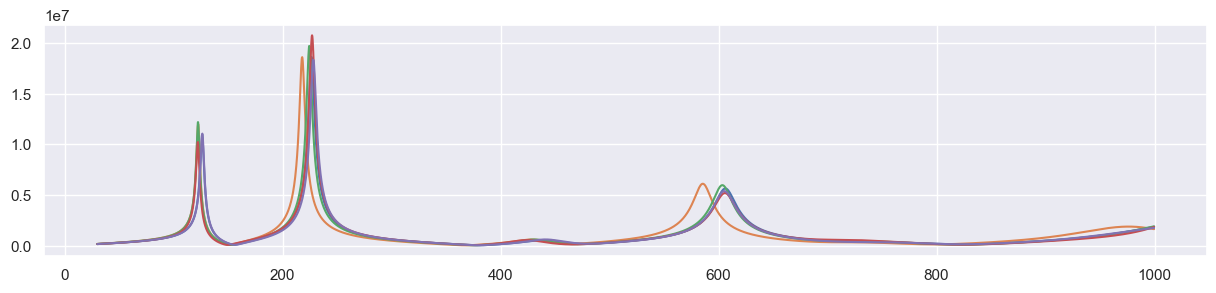

In [322]:
for geo in geos:
    s=Geo(geo).get_cadsd().get_impedance_spektrum()
    plt.plot(s.freq, s.impedance)

In [302]:
ls ../../evolutions/2023-09-06T11-02-01_test_evolve

checkpoint_100/     checkpoint_final_2/ log.txt
checkpoint_final_1/ checkpoint_final_3/ losses.csv


In [304]:
get_impedance_spektrum()

AttributeError: 'DataFrame' object has no attribute 'get_impedance_spektrum'

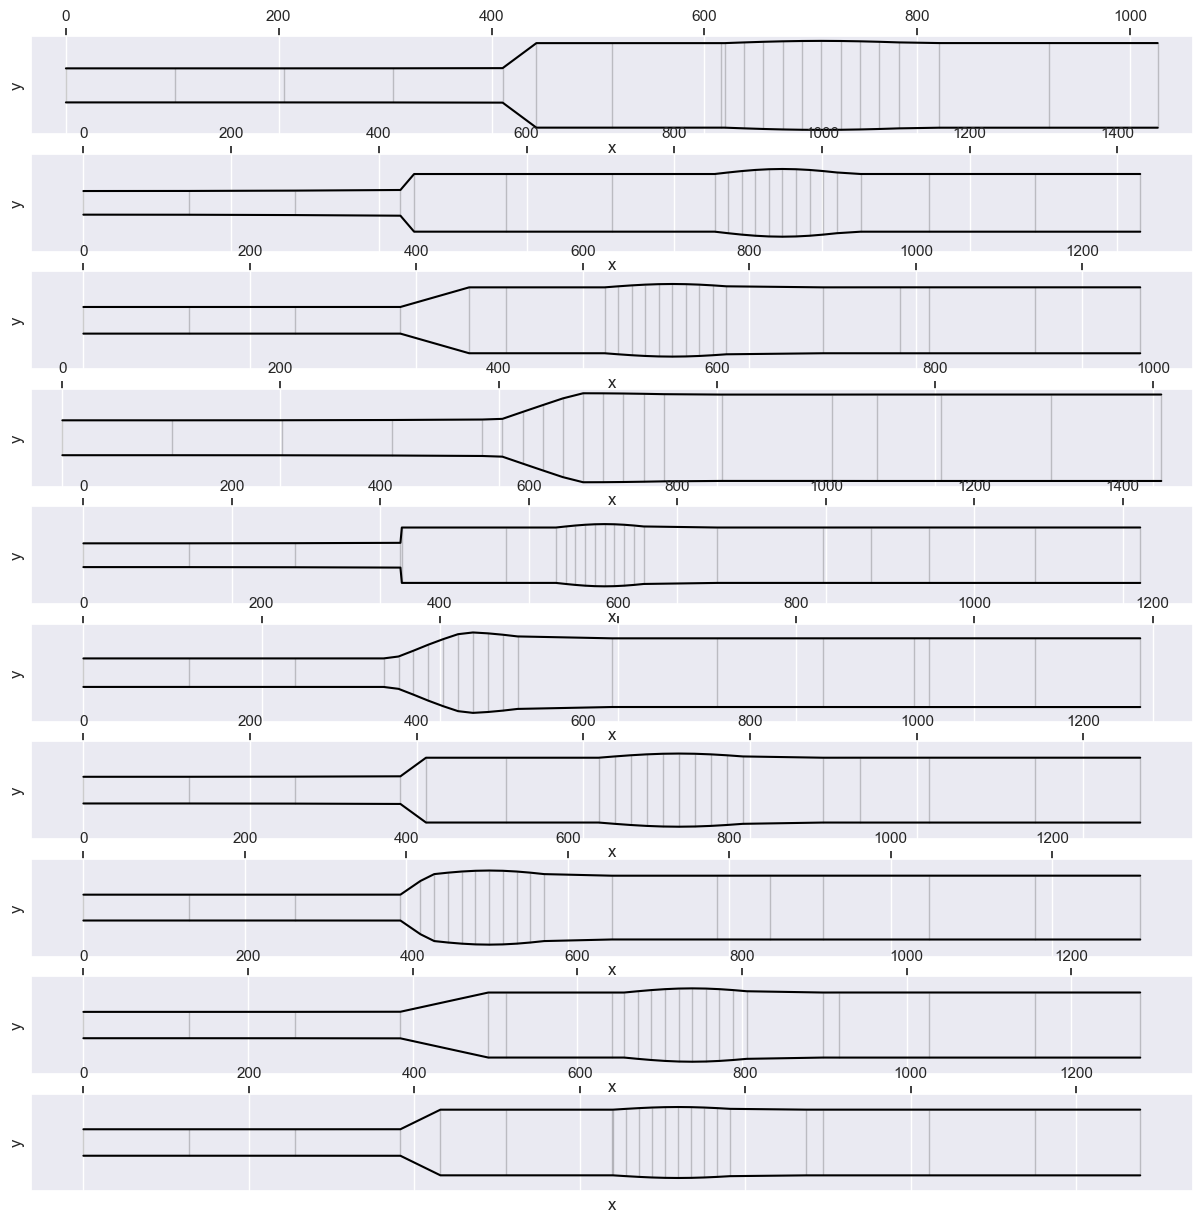

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
n_mutants = 8
for i in range(len(geos)):
    plt.subplot(len(geos), 1, i+1)
    vis_didge(Geo(geos[i]))


In [63]:
from didgelab.evo.loss import LossFunction

class ScaleTuningLoss(LossFunction):
        
    def __init__(self, base_note, target_scale):
        LossFunction.__init__(self)
        
        self.base_note = base_note

        f=note_to_freq(self.base_note)
        i=0
        self.target_freqs = []

        target_notes = []
        while True:
            target_notes.extend(np.array(target_scale) + self.base_note + 12*i)
            i+=1
            if note_to_freq(target_notes[-1])>1000 or i>100:
                break

        self.target_freqs = np.log2(note_to_freq(np.array(target_notes)))

    def get_deviations(self, freq, reference):
        
        deviations = []
        for f in freq:
            d = [np.abs(r-f) for r in reference]
            deviations.append(np.min(d))
        return deviations
        
    def get_loss(self, geo, context=None):
        
        notes = geo.get_cadsd().get_notes()
        freqs = np.log2(list(notes.freq))
        
        fundamental_loss = self.get_deviations([freqs[0]], [self.target_freqs[0]])[0]
        print(np.power(2,self.target_freqs[0]))
        print(fundamental_loss)
        fundamental_loss *= 10
        
        deviations = self.get_deviations(freqs[1:], self.target_freqs)

        toots_loss = np.sum(deviations[1:])/2
        toots_loss *= 3
        toots_loss = 0

        amp_loss = 1-np.mean(list(notes.rel_imp)[1:])
        amp_loss *= 2
        amp_loss = 0
        
        loss = {
            "loss": fundamental_loss + toots_loss + amp_loss,
            "fundamental_loss": fundamental_loss,
            "toots_loss": toots_loss,
            "amp_loss": amp_loss
        }
        return loss
    
loss = ScaleTuningLoss(base_note=-31, target_scale=[0,3,5,7,10])
shape = BasicShape()

n_mutants=3
mutants = [mutator.mutate(father) for i in range(n_mutants)]
np.random.seed(0)
for mutant in mutants:
    geo=mutant.make_geo()
    f=geo.get_cadsd().get_notes().iloc[0]["freq"]
    print(f)
    print(loss.get_loss(geo))
    print()

74.3824619963392
73.41619197935188
0.018864215417192298
{'loss': 0.18864215417192298, 'fundamental_loss': 0.18864215417192298, 'toots_loss': 0, 'amp_loss': 0}

72.51582338080608
73.41619197935188
0.017802451249473883
{'loss': 0.17802451249473883, 'fundamental_loss': 0.17802451249473883, 'toots_loss': 0, 'amp_loss': 0}

78.080511326516
73.41619197935188
0.08886421541719258
{'loss': 0.8886421541719258, 'fundamental_loss': 0.8886421541719258, 'toots_loss': 0, 'amp_loss': 0}



In [185]:
r = []
values = np.array([1.5])
for i in range(100):
    maxima = np.array([2])
    minima = np.array([1])

    mutation_rate = 1.0
    mutation_probability = 1.0
    diff = mutation_rate * ((np.random.random(len(values))  * (maxima-minima) ) + minima - values)

    mutations = np.array([0.0])
    i=0
    while mutations.sum() == 0.0 and i<3:
        mutations = np.random.choice((1,0), size=len(diff), p=(mutation_probability, 1-mutation_probability))
        i+=1

    diff = diff*mutations

    values = values + diff

    r.append(values[0])
    
print(np.min(r))
print(np.max(r))

1.030928846860542
1.9949401296323233


In [112]:
def get_closest_index(haystack, needle, offset=0):
    d1=100000
    d2=100000
    for i in range(offset, len(haystack)):
        d3 = np.abs(haystack[i]-needle)
        if d2<d3:
            if d1<d2:
                return i-2
            else:
                return i-1
        d1=d2
        d2=d3
    return i

haystack = np.arange(0,5,0.3)
needle = 1.4
print(haystack)
print(get_closest_index(haystack, needle, offset=2))

[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3.  3.3 3.6 3.9 4.2 4.5 4.8]
5


In [116]:
list(range(2,5+1))

[2, 3, 4, 5]